In [1]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import statsmodels.stats as stat
import sys
import scipy
#import pickle5 as pickle
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

In [3]:
os.listdir(os.path.dirname(os.getcwd()) + '\\backtest\\strategy_file')

['beta_avg_diff_strat1.csv',
 'IV_per_volume_diff_strat1.csv',
 'IV_per_volume_diff_strat2.csv',
 'lasso_strat2_close_51.csv',
 'lgbm_close_31_strat.csv',
 'lgbm_strat2_close_51.csv',
 'sabr_value_diff_strat1.csv',
 'sabr_value_diff_strat2.csv',
 'sabr_vol_diff_min_strat1.csv',
 'sabr_vol_diff_strat2.csv',
 'strategy_1.csv',
 'strategy_test.csv']

In [46]:
#settings
work_path = os.path.dirname(os.getcwd())
current_time = time.strftime("%Y%m%d%H%M", time.localtime())
exp_name = 'sabr_value_diff_strat1' #策略名
factor_file_path = work_path + '\\backtest\\strategy_file\\%s.csv' %exp_name #策略文件名，保存的三列名称为option_name,trade_time,position
exp_name = exp_name + '_'+ current_time
save_path = work_path + '\\backtest\%s' %exp_name

In [47]:
#ifind_data_format
pd.read_pickle(work_path + '\\03_data\\300etf_option2207.pkl')

,time,code,open,high,low,close,volume,option_code,type,maturity_date,strike
0,2022-05-26 09:35:00,10004299.SH,0.3987,0.3987,0.3987,0.3987,1.0,510300C2207M03600,1,2022-07-27 15:30:00,3.6
1,2022-05-26 09:35:00,10004300.SH,0.3146,0.3146,0.3025,0.3025,3.0,510300C2207M03700,1,2022-07-27 15:30:00,3.7
2,2022-05-26 09:35:00,10004301.SH,0.2454,0.2454,0.2317,0.2361,16.0,510300C2207M03800,1,2022-07-27 15:30:00,3.8
3,2022-05-26 09:35:00,10004302.SH,0.1808,0.1808,0.1645,0.1718,293.0,510300C2207M03900,1,2022-07-27 15:30:00,3.9
4,2022-05-26 09:35:00,10004303.SH,0.1227,0.1244,0.1158,0.1180,220.0,510300C2207M04000,1,2022-07-27 15:30:00,4.0
...,...,...,...,...,...,...,...,...,...,...,...
52699,2022-07-27 15:00:00,10004334.SH,0.4293,0.4293,0.4293,0.4293,0.0,510300P2207M04700,-1,2022-07-27 15:30:00,4.7
52700,2022-07-27 15:00:00,10004379.SH,0.0001,0.0001,0.0001,0.0001,9.0,510300C2207M04800,1,2022-07-27 15:30:00,4.8
52701,2022-07-27 15:00:00,10004380.SH,0.5287,0.5287,0.5287,0.5287,0.0,510300P2207M04800,-1,2022-07-27 15:30:00,4.8
52702,2022-07-27 15:00:00,10004391.SH,0.0001,0.0001,0.0001,0.0001,9.0,510300C2207M04900,1,2022-07-27 15:30:00,4.9


In [48]:
pd.read_csv(factor_file_path,index_col = 0)

,time,code,open,high,low,close,volume,option_code,type,maturity_date,...,out moneyness,margin,fund_cost,cash_net,delta_p,vega_p,arbi,gamma_p,theta_p,notional
0,2022-05-26 09:35:00,10004300.SH,0.3146,0.3146,0.3025,0.3025,3.0,510300C2207M03700,C,2022-07-27 15:30:00,...,3.3975,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000
1,2022-05-26 09:35:00,10004301.SH,0.2454,0.2454,0.2317,0.2361,16.0,510300C2207M03800,C,2022-07-27 15:30:00,...,3.5639,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000
2,2022-05-26 09:35:00,10004302.SH,0.1808,0.1808,0.1645,0.1718,293.0,510300C2207M03900,C,2022-07-27 15:30:00,...,3.7282,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000
3,2022-05-26 09:35:00,10004303.SH,0.1227,0.1244,0.1158,0.1180,220.0,510300C2207M04000,C,2022-07-27 15:30:00,...,3.8820,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000
4,2022-05-26 09:35:00,10004304.SH,0.0819,0.0832,0.0758,0.0774,388.0,510300C2207M04100,C,2022-07-27 15:30:00,...,4.0226,0.0,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27701,2022-07-25 15:00:00,10004305.SH,0.0770,0.0773,0.0750,0.0763,1443.0,510300C2207M04200,C,2022-07-27 15:30:00,...,4.1237,96250.0,0.320833,-830.320833,79.314555,21.480000,130.144121,435.340652,-1.762774,427.100
27702,2022-07-25 15:00:00,10004306.SH,0.0145,0.0146,0.0137,0.0140,4161.0,510300C2207M04300,C,2022-07-27 15:30:00,...,4.2860,1711587.5,5.705292,2164.294708,-121.862303,89.618206,-71.522101,-2072.861882,10.204715,1853.614
27703,2022-07-25 15:00:00,10004314.SH,0.0070,0.0075,0.0070,0.0071,1652.0,510300P2207M04200,P,2022-07-27 15:30:00,...,0.0000,121100.0,0.403667,1383.596333,-286.286565,297.283197,-238.722889,6022.809806,-24.396794,5911.064
27704,2022-07-25 15:00:00,10004315.SH,0.0437,0.0446,0.0433,0.0443,3494.0,510300P2207M04300,P,2022-07-27 15:30:00,...,0.0000,-0.0,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000


In [49]:
#preprocessing strategy data
position_data = pd.read_csv(factor_file_path,index_col = 0)
position_data['position'] = position_data.profit_position + position_data.hedge_position
#position_data['position'] = position_data.profit_position
position_data = position_data[['time','code','position']]
position_data.time = position_data.time.apply(lambda x:x[:-3])
position_data = position_data.rename(columns={'time':'trade_time','code':'option_name'})
position_data.trade_time = pd.to_datetime(position_data.trade_time)
position_data = position_data.fillna(0)

In [50]:
#strategy data_format
position_data

,trade_time,option_name,position
0,2022-05-26 09:35:00,10004300.SH,0.0
1,2022-05-26 09:35:00,10004301.SH,0.0
2,2022-05-26 09:35:00,10004302.SH,0.0
3,2022-05-26 09:35:00,10004303.SH,0.0
4,2022-05-26 09:35:00,10004304.SH,0.0
...,...,...,...
27701,2022-07-25 15:00:00,10004305.SH,100.0
27702,2022-07-25 15:00:00,10004306.SH,-434.0
27703,2022-07-25 15:00:00,10004314.SH,1384.0
27704,2022-07-25 15:00:00,10004315.SH,0.0


In [51]:
#position_data statistic metrics
position_data.position.describe()

count    27706.000000
mean        13.693821
std        193.937742
min      -3628.000000
25%         -6.000000
50%          0.000000
75%         30.000000
max       5652.000000
Name: position, dtype: float64

<AxesSubplot:xlabel='position', ylabel='Count'>

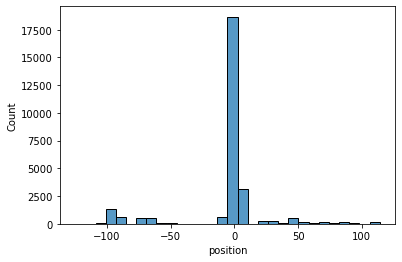

In [30]:
#position_data histplot
sns.histplot(position_data.position,bins=30)

In [8]:
def delete_singular_value(ts):
    max_singular = ts.rolling(100,min_periods = 100).quantile(0.99)
    min_singular = ts.rolling(100,min_periods = 100).quantile(0.01)
    ts[ts>max_singular] = 0
    ts[ts<min_singular] = 0
    return ts

position_data.position = position_data.groupby('option_name').apply(lambda x: delete_singular_value(x['position']))


In [21]:
def transaction_cost(position,transaction_cost_b = 0,transaction_cost_s = 0):
    if position>0:
        cost = position*transaction_cost_b
    else:
        cost = position*transaction_cost_s
    return cost


2022

In [52]:
#data_reprocessing for ifind data
data_ifind = pd.read_pickle(work_path + '\\03_data\\300etf_option2207.pkl')
data_etf = pd.read_pickle(work_path+'\\03_data\\300etf.pkl')
data_ifind = pd.merge(data_ifind,data_etf,how="outer")

data_ifind = data_ifind.rename(columns={'thscode':'option_name','time':'trade_time','code':'option_name','datetime':'trade_time'})

data_ifind = data_ifind.sort_values(['option_name','trade_time'])
data_ifind = data_ifind.groupby('option_name').apply(lambda x:x.sort_values(["trade_time",'option_name']))

data_ifind = pd.DataFrame(columns = data_ifind.columns,data = data_ifind.values)

data_ifind['buy_price'] = data_ifind.groupby('option_name').apply(lambda x:(x.close.shift(1))).values

data_ifind['ret'] = data_ifind.groupby(['option_name']).apply(lambda x:x.close.pct_change()).values

#position_data = pd.read_csv(factor_file_path,index_col = 0)

bk = pd.merge(position_data,data_ifind,how="left",on=["option_name","trade_time"])
bk['year'] = bk['trade_time'].apply(lambda x:x.year)
bk['month'] = bk['trade_time'].apply(lambda x:x.month)
bk['day'] = bk['trade_time'].apply(lambda x:x.day)
bk['position_diff'] = bk.groupby('option_name')['position'].diff().values
bk['trade_time'] = pd.to_datetime(bk['trade_time'])
bk = bk.dropna()
bk['transaction_direction'] = 'N'
bk['transaction_volume'] = 0
bk.loc[bk.position_diff>0,'transaction_direction'] = 'B'
bk.loc[(bk.position_diff<0) & (bk.position<0),'transaction_direction'] = 'S'
bk.loc[bk.position_diff>0,'transaction_volume'] = bk.position_diff
bk.loc[(bk.position_diff<0) & (bk.position<0) & (bk.position_diff>bk.position),'transaction_volume'] = abs(bk.position_diff)
bk.loc[(bk.position_diff<0) & (bk.position<0) & (bk.position_diff<bk.position),'transaction_volume'] = abs(bk.position)
bk[['close','ret']] = bk[['close','ret']].applymap(lambda x:float(x))

bk.head()

,trade_time,option_name,position,open,high,low,close,volume,option_code,type,maturity_date,strike,buy_price,ret,year,month,day,position_diff,transaction_direction,transaction_volume
16,2022-05-26 09:40:00,10004300.SH,1.0,0.2973,0.2973,0.2938,0.2938,2.0,510300C2207M03700,1,2022-07-27 15:30:00,3.7,0.3025,-0.028760,2022,5,26,1.0,B,1
17,2022-05-26 09:40:00,10004301.SH,6.0,0.2265,0.2265,0.2198,0.2209,13.0,510300C2207M03800,1,2022-07-27 15:30:00,3.8,0.2361,-0.064380,2022,5,26,6.0,B,6
18,2022-05-26 09:40:00,10004302.SH,100.0,0.168,0.1686,0.1588,0.1588,245.0,510300C2207M03900,1,2022-07-27 15:30:00,3.9,0.1718,-0.075669,2022,5,26,100.0,B,100
19,2022-05-26 09:40:00,10004303.SH,100.0,0.1177,0.1177,0.1076,0.1076,1202.0,510300C2207M04000,1,2022-07-27 15:30:00,4.0,0.118,-0.088136,2022,5,26,100.0,B,100
20,2022-05-26 09:40:00,10004304.SH,100.0,0.0762,0.0762,0.0699,0.0703,715.0,510300C2207M04100,1,2022-07-27 15:30:00,4.1,0.0774,-0.091731,2022,5,26,100.0,B,100


In [55]:
def backtest(df,transaction_cost_b = 0,transaction_cost_s = 0,initial_capital = 10**6,Period = False):
    time_list = list(df['trade_time'].unique())
    time_list = sorted(time_list)
    backtest = {}
    pnl_tick = []
    ic = []
    pnl_capital = [initial_capital]
    tvr_tick = []
    gross_profit_tick = []
    net_profit_tick = []
    transactio_cost = {'B':transaction_cost_b,'S':transaction_cost_s,'N':0}
    for t in tqdm(time_list):
        sub_bk = df[df['trade_time']==t]
        ic.append(sub_bk[['position','ret']].corr().iloc[0,1])
        sub_bk['money_position'] = sub_bk['position']*sub_bk['buy_price']*10000
        sub_bk['transaction_cost'] = sub_bk['transaction_volume']*sub_bk['transaction_direction'].apply(lambda x:transactio_cost[x])
        sub_bk['net_profit'] = (sub_bk['money_position']*sub_bk['ret'] - sub_bk['transaction_cost'])
        sub_bk['gross_profit'] = sub_bk['money_position']*sub_bk['ret']
        pnl_tick.append((sub_bk['net_profit']/pnl_capital[-1]).sum())
        #pnl_tick.append((sub_bk.loc[sub_bk['money_position']!=0,'net_profit']/abs(sub_bk.loc[sub_bk['money_position']!=0,"money_position"])).sum())
        tvr_tick.append(((sub_bk['transaction_volume']*sub_bk['buy_price'])/pnl_capital[-1]).sum())
        pnl_capital.append(pnl_capital[-1] + sub_bk['net_profit'].sum())
        gross_profit_tick.append(sub_bk['gross_profit'].sum())
        net_profit_tick.append(sub_bk['net_profit'].sum())
    ir = np.mean(ic)/np.std(ic)
    ic = np.mean(ic)
    temp_df = pd.Series(pnl_tick, index = time_list)
    gross_profit_df = pd.Series(gross_profit_tick,index = time_list)
    net_profit_df = pd.Series(net_profit_tick,index = time_list)
    pnl_capital = pd.Series(pnl_capital[1:],index=time_list)
    daily_ret = temp_df.resample('1d').sum()
    annual_ret = daily_ret.mean()*252
    annual_vol = daily_ret.std()*np.sqrt(252)
    
    pnl = (1+temp_df).cumprod()
    maxdd = abs((pnl - pnl.cummax()).cummin())
    tvr = pd.Series(tvr_tick,index=time_list).sum()
    #win_rate =  df.groupby('trade_time').apply(lambda x:(x['position']*x['ret']>0).sum()/((x['position']!=0).sum()).mean()
    win_rate = df.groupby('trade_time').apply(lambda x:(x['position_diff'] * x['ret'] >0).sum()/((x['position_diff']!=0).sum())).mean()
    os.mkdir(save_path)
    backtest['long'] = df.loc[bk['position']>0,'position'].mean()
    backtest['short'] = df.loc[bk['position']<0,'position'].mean()
    backtest['ir'] = ir
    backtest['ic'] = ic
    backtest['SR'] = temp_df.mean()/temp_df.std()  #???
    backtest['Annualized_Ret'] = annual_ret
    backtest['Annualized_SR'] = annual_ret/annual_vol
    backtest['Net_Ret'] = pnl[-1]
    backtest['Net_Profit'] = net_profit_df.sum()
    backtest['Gross_Profit'] = gross_profit_df.sum()
    backtest['maxdd'] = maxdd.iloc[-1]
    backtest['tvr'] = tvr
    backtest['win'] = win_rate
    pnl.index = pnl.index.strftime("%Y-%m-%d-%H:%M")
    pnl_capital.index = pnl_capital.index.strftime("%Y-%m-%d-%H:%M")
    maxdd.index = maxdd.index.strftime("%Y-%m-%d-%H:%M")
    res_ts = pd.DataFrame()
    res_ts['cumulative_return'] = pnl
    res_ts['cumulative_capital'] = pnl_capital
    res_ts['maxdd'] = maxdd
    if not Period:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, 'result.png'))
        pd.DataFrame(pd.Series(backtest),columns = ["value"]).to_csv(os.path.join(save_path, 'result.csv'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    else:
        fig = res_ts.plot(figsize = (10,10),grid = True, subplots = True)
        fig[-1].figure.savefig(os.path.join(save_path, f'{Period}_result.png'))
        res_ts.to_csv(os.path.join(save_path, 'result_TimeSeries.csv'))
    return backtest,res_ts
    
        
        
        
        

100%|██████████████████████████████████████████████████████████████████████████████| 2015/2015 [02:44<00:00, 12.23it/s]


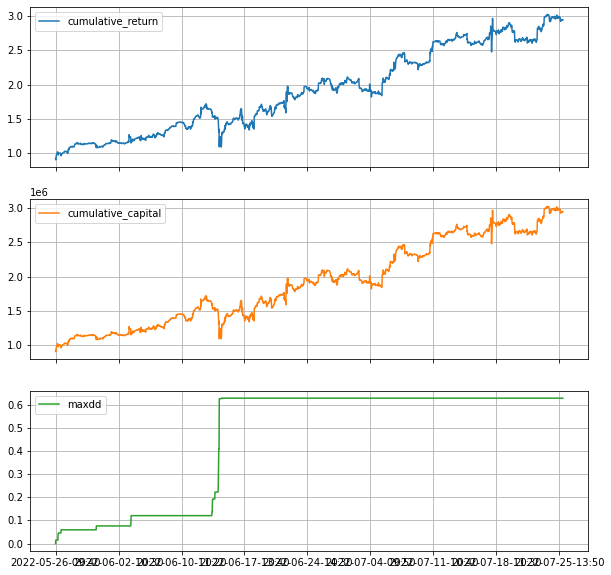

In [56]:
backtest_res,res_ts = backtest(bk,transaction_cost_b= 1.3,transaction_cost_s= 0,initial_capital=10**6)

In [89]:
#backtest by period, method = {"year","month"}
#can produce result grouped by period
def backtest_period(df,transaction_cost = 0,initial_capital = 10**6,method = 'year'):
    backtest_period = {}
    pnl_period = {}
    if method == "year":
        period_list = df[method].unique()
        backtest_res = df.groupby(method).apply(lambda x:backtest(x,transaction_cost,initial_capital,f"{x.trade_time.iloc[0].year}")[0])
    else:
        period_list = (df['year'] + df['month']).unique()
        backtest_res = df.groupby(["year",method]).apply(lambda x:backtest(x,transaction_cost,initial_capital,\
                                                                  f"{x.trade_time.iloc[0].year}_{x.trade_time.iloc[0].month}")[0])
    for period in period_list:
        if method =="year":
            backtest_period[period] = backtest_res[period]
        else:
            backtest_period[(period[:4],period[4:])] = backtest_res[(period[:4],period[4:])]
    pd.DataFrame(backtest_period).T.to_csv(os.path.join(save_path, f'result_{method}.csv'))
    return

100%|███████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 229.44it/s]


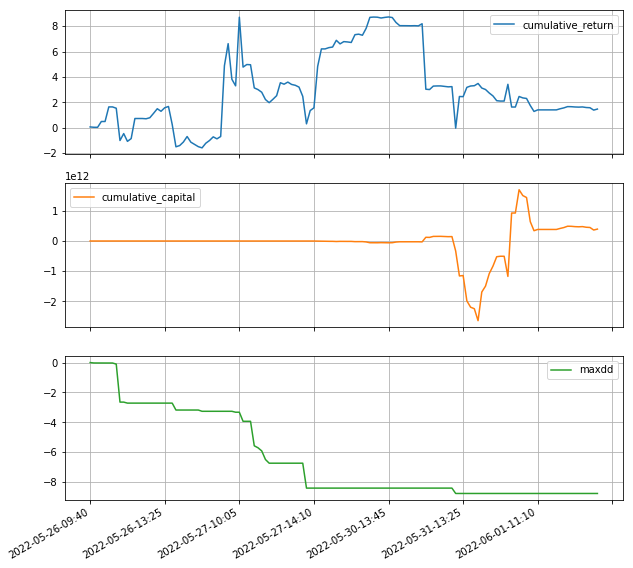

In [90]:
os.mkdir(save_path)
backtest_res,res_ts = backtest(bk,transaction_cost=0,initial_capital=10**6)

100%|███████████████████████████████████████████████████████████████████████████████| 816/816 [00:03<00:00, 243.72it/s]


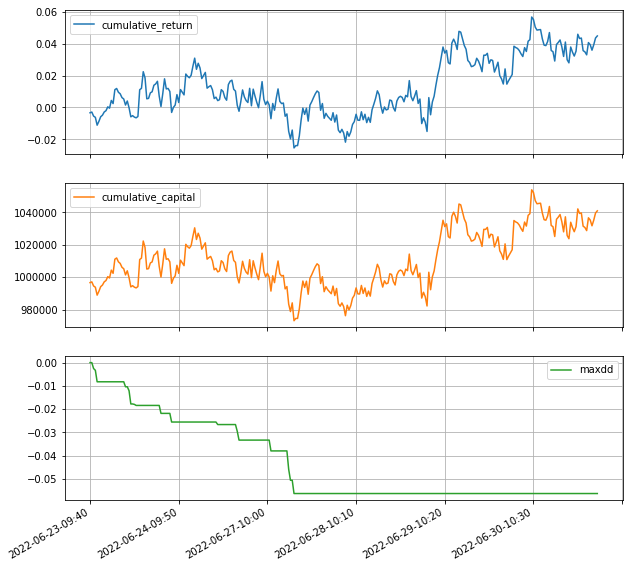

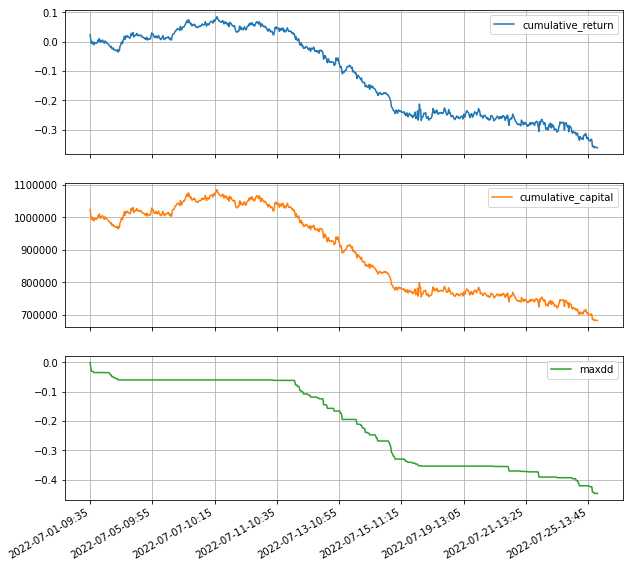

In [77]:
backtest_period(bk,transaction_cost=1.5,initial_capital=10**6,method = "month")